# Examining the data of Car Model store

In this project I will be using SQL and Python libraries to draw out a picture of the data of car model store.
We will see what the company can do to get the most out of their investments. We will be looking at the customer data to see what customers spend the most and the least as well as geographical data to see what countries give the best opportunity for growth. This will help draw out an accurate picture of companies statistics.

In [ ]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('stores.db')

In [ ]:
# first we just layout all the sub databases and their attributes inside the main database to get an accurate picture
q1 = pd.read_sql('''SELECT 'customers' AS table_name, 13 AS num_of_attributes, count(*) AS num_of_rows FROM customers
                  UNION ALL
                  SELECT 'products' AS table_name, 9 AS num_of_attributes, count(*) AS num_of_rows FROM products
                  UNION ALL
                  SELECT 'productlines' AS table_name, 4 AS num_of_attributes, count(*) AS num_of_rows FROM productlines
                  UNION All
                  SELECT 'orders' AS table_name, 7 AS num_of_attributes, count(*) AS num_of_rows FROM orders
                  UNION ALL
                  SELECT 'orderdetails' AS table_name, 5 AS num_of_attributes, count(*) AS num_of_rows FROM orderdetails
                  UNION ALL
                  SELECT 'payments' AS table_name, 4 AS num_of_attributes, count(*) AS num_of_rows FROM payments
                  UNION ALL
                  SELECT 'employees' AS table_name, 8 AS num_of_attributes, count(*) AS num_of_rows FROM employees
                  UNION ALL
                  SELECT 'offices' AS table_name, 9 AS num_of_attributes, count(*) AS num_of_rows FROM offices''', conn)
print(q1)

     table_name  num_of_attributes  num_of_rows
0     customers                 13          122
1      products                  9          110
2  productlines                  4            7
3        orders                  7          326
4  orderdetails                  5         2996
5      payments                  4          273
6     employees                  8           23
7       offices                  9            7


In [ ]:
# Low stock products
q2 = '''SELECT ROUND(Sum(quantityOrdered)/(SELECT quantityInStock
									FROM  products p
									WHERE od.productCode=p.productCode),2) AS low_stock, productCode
                  FROM  orderdetails od
                  GROUP BY productCode
                  ORDER BY low_stock DESC
                  LIMIT 10'''
results = pd.read_sql_query(q2,conn)
print(results)

   low_stock productCode
0       67.0    S24_2000
1       13.0    S12_1099
2        7.0    S32_4289
3        5.0    S32_1374
4        2.0    S72_3212
5        1.0   S700_3167
6        1.0   S700_1938
7        1.0    S50_4713
8        1.0    S32_3522
9        1.0    S18_2795


In [ ]:
# also lets see the best performing products
q3 = '''SELECT SUM(quantityOrdered*priceEach) AS prod_perfor, productCode
FROM orderdetails od
GROUP BY productCode
ORDER BY prod_perfor DESC
LIMIT 10'''
results = pd.read_sql_query(q3,conn)
print(results)

   prod_perfor productCode
0    276839.98    S18_3232
1    190755.86    S12_1108
2    190017.96    S10_1949
3    170686.00    S10_4698
4    161531.48    S12_1099
5    152543.02    S12_3891
6    144959.91    S18_1662
7    142530.63    S18_2238
8    140535.60    S18_1749
9    135767.03    S12_2823


In [ ]:
# now we can group q2 and q3 to find the products which are the most popular
q4 = '''WITH low_stock_products AS (
SELECT ROUND(Sum(quantityOrdered)/(SELECT quantityInStock
									FROM  products p
									WHERE od.productCode=p.productCode),2) AS low_stock, productCode
FROM  orderdetails od
GROUP BY productCode
ORDER BY low_stock DESC
LIMIT 10
),
priority_products AS (
SELECT SUM(quantityOrdered*priceEach) AS prod_perfor, productCode
FROM orderdetails od
WHERE productCode IN (SELECT productCode
						FROM low_stock_products)
GROUP BY productCode
ORDER BY prod_perfor DESC
LIMIT 10
)
SELECT productName, productLine
FROM products p
WHERE productCode IN (SELECT productCode
						FROM priority_products)'''
results = pd.read_sql_query(q4,conn)
print(results)

                                   productName       productLine
0                            1968 Ford Mustang      Classic Cars
1                       1928 Mercedes-Benz SSK      Vintage Cars
2                     1960 BSA Gold Star DBD34       Motorcycles
3                             1997 BMW F650 ST       Motorcycles
4  1996 Peterbilt 379 Stake Bed with Outrigger  Trucks and Buses
5                     1928 Ford Phaeton Deluxe      Vintage Cars
6                           2002 Yamaha YZR M1       Motorcycles
7                                The Mayflower             Ships
8                           F/A 18 Hornet 1/72            Planes
9                                   Pont Yacht             Ships


In [ ]:
# We can also find the VIP clients, clients who spend the most
q5 = '''WITH customer_profit AS (
SELECT o.customerNumber AS customer_number, Sum(od.quantityOrdered*(od.priceEach-p.buyPrice)) AS profit
FROM products p
JOIN orderdetails od
ON p.productCode=od.productCode
JOIN orders o
ON od.orderNumber=o.orderNumber
GROUP BY o.customerNumber
LIMIT 5
)
SELECT c.contactLastName, c.contactFirstName, c.city, c.country, cp.profit
FROM customers c
JOIN customer_profit cp
ON  c.customerNumber=cp.customer_number
ORDER BY cp.profit DESC
LIMIT 5'''
results = pd.read_sql_query(q5,conn)
print(results)

  contactLastName contactFirstName       city    country    profit
0        Ferguson            Peter  Melbourne  Australia  70311.07
1         Labrune          Janine      Nantes     France  60875.30
2      Bergulfsen           Jonas     Stavern     Norway  41391.52
3            King             Jean  Las Vegas        USA  31312.72
4         Schmitt          Carine      Nantes     France  10063.80


In [ ]:
# Now the least profitable customers
q6 = '''WITH customer_profit AS (
SELECT o.customerNumber AS customer_number, Sum(od.quantityOrdered*(od.priceEach-p.buyPrice)) AS profit
FROM products p
JOIN orderdetails od
ON p.productCode=od.productCode
JOIN orders o
ON od.orderNumber=o.orderNumber
GROUP BY o.customerNumber
)
SELECT c.contactLastName, c.contactFirstName, c.city, c.country, cp.profit
FROM customers c
JOIN customer_profit cp
ON  c.customerNumber=cp.customer_number
ORDER BY cp.profit
LIMIT 5'''
results = pd.read_sql_query(q6,conn)
print(results)

  contactLastName contactFirstName        city country    profit
0           Young             Mary    Glendale     USA   2610.87
1          Taylor           Leslie  Brickhaven     USA   6586.02
2         Ricotti           Franco       Milan   Italy   9532.93
3         Schmitt          Carine       Nantes  France  10063.80
4           Smith          Thomas       London      UK  10868.04


In [ ]:
# we can also determine the customer lifetime average, that is the average amount a customer spends on products
q7 = '''WITH LTV_table AS (
SELECT o.customerNumber AS customer_number, Sum(od.quantityOrdered*(od.priceEach-p.buyPrice)) AS profit
FROM products p
JOIN orderdetails od
ON p.productCode=od.productCode
JOIN orders o
ON od.orderNumber=o.orderNumber
GROUP BY o.customerNumber
)
SELECT AVG(ltv.profit) AS lifetime_average, c.contactLastName AS last_name, c.contactFirstName AS first_name
FROM LTV_table AS ltv
JOIN customers AS c
ON ltv.customer_number = c.customerNumber
GROUP BY ltv.customer_number
ORDER BY lifetime_average DESC
LIMIT 10'''
results = pd.read_sql_query(q7,conn)
print(results)

   lifetime_average  last_name first_name
0         326519.66     Freyre     Diego 
1         236769.39     Nelson      Susan
2          72370.09      Young       Jeff
3          70311.07   Ferguson      Peter
4          60875.30    Labrune    Janine 
5          60477.38  Natividad       Eric
6          60095.86   Ashworth     Rachel
7          60013.99     Graham       Mike
8          58669.10        Lee       Kwai
9          55931.37      Frick        Sue


In [ ]:
# And the overall LTV average of all customers
q8 ='''WITH LTV_table AS (
SELECT o.customerNumber AS customer_number, Sum(od.quantityOrdered*(od.priceEach-p.buyPrice)) AS profit
FROM products p
JOIN orderdetails od
ON p.productCode=od.productCode
JOIN orders o
ON od.orderNumber=o.orderNumber
GROUP BY o.customerNumber
)
SELECT ROUND(AVG(ltv.profit),2) AS ltv
FROM LTV_table AS ltv'''
results = pd.read_sql_query(q8,conn)
print(results)

        ltv
0  39039.59


So overhere we determined the customer lifetime average to be around
39039 USD, in other words an average customer spends around 39039 USD
on products. So if we get around 10 new customers we can expect to make around
390,395 USD and based on this we can think of how much money to invest
to get more customers

In [ ]:
# we can also determine the average profit all countries the store sells in
q10='''
WITH CountryProfit AS (
    SELECT
        c.country AS country,
        SUM(od.quantityOrdered * (od.priceEach - p.buyPrice)) AS total_profit
    FROM products p
    JOIN orderdetails od ON p.productCode = od.productCode
    JOIN orders o ON od.orderNumber = o.orderNumber
    JOIN customers c ON o.customerNumber = c.customerNumber
    GROUP BY c.country
)
SELECT ROUND(AVG(total_profit), 2) AS Avg_profit
FROM CountryProfit'''
results = pd.read_sql_query(q10,conn)
print(results)


   Avg_profit
0   173903.65


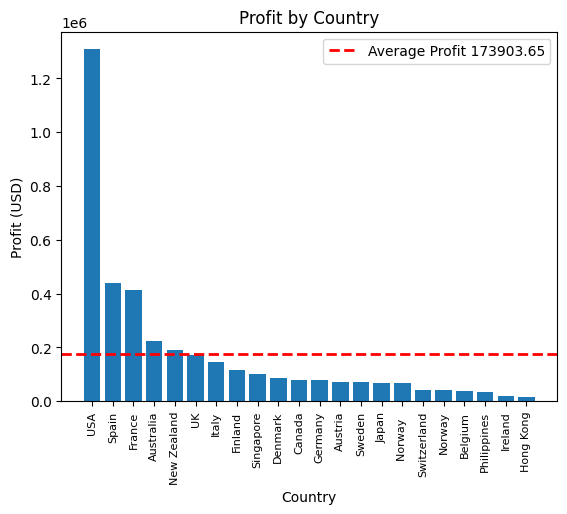

In [ ]:
# now lets determine the profit per country and visualize, comparing it to the average computed above to get a better idea
import matplotlib.pyplot as plt
q9 =  '''
WITH CountryProfit AS (
    SELECT
        c.country AS country,
        SUM(od.quantityOrdered * (od.priceEach - p.buyPrice)) AS total_profit
    FROM products p
    JOIN orderdetails od ON p.productCode = od.productCode
    JOIN orders o ON od.orderNumber = o.orderNumber
    JOIN customers c ON o.customerNumber = c.customerNumber
    GROUP BY c.country
)
SELECT
    country,
    ROUND(AVG(total_profit), 2) AS profit
FROM CountryProfit
GROUP BY country
ORDER BY profit DESC
'''
results = pd.read_sql_query(q9,conn)
import matplotlib.pyplot as plt
plt.bar(results['country'], results['profit'])
plt.xlabel('Country')
plt.ylabel('Profit (USD)')
plt.title('Profit by Country')
plt.xticks(rotation=90, fontsize=8)
import numpy as np
plt.axhline(y=np.mean(results['profit']), color='r', linestyle='--', linewidth=2, label=f'Average Profit {np.mean(results["profit"]):.2f}')
plt.legend()
plt.show()

We can also examine the per captia average of profit by country, in other words the profit each country makes per capita as opposed to the overall average as given above.

In [ ]:
# examine the average profit per customer per  all countries
q10 = '''WITH LTV_table AS (
SELECT o.customerNumber AS customer_number, Sum(od.quantityOrdered*(od.priceEach-p.buyPrice)) AS profit
FROM products p
JOIN orderdetails od
ON p.productCode=od.productCode
JOIN orders o
ON od.orderNumber=o.orderNumber
GROUP BY o.customerNumber
),
avg_country_profit AS (
SELECT ROUND(AVG(ltv.profit),2) AS lifetime_average_per_country, c.country AS country
FROM LTV_table AS ltv
JOIN customers AS c
ON ltv.customer_number = c.customerNumber
GROUP BY c.country
ORDER BY lifetime_average_per_country DESC
)
SELECT ROUND(AVG(lifetime_average_per_country),2) AS avg_total_percaptia
FROM avg_country_profit; '''
results = pd.read_sql_query(q10,conn)
print(results)

   avg_total_percaptia
0             37400.32


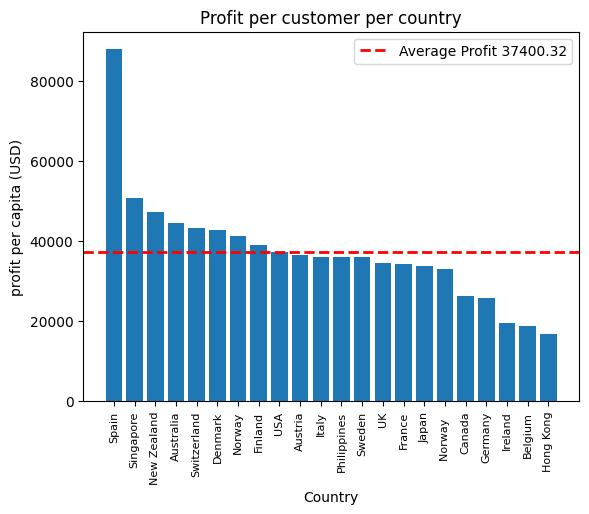

In [ ]:
# lets visualize the results above
q11 = '''WITH LTV_table AS (
SELECT o.customerNumber AS customer_number, Sum(od.quantityOrdered*(od.priceEach-p.buyPrice)) AS profit
FROM products p
JOIN orderdetails od
ON p.productCode=od.productCode
JOIN orders o
ON od.orderNumber=o.orderNumber
GROUP BY o.customerNumber
)
SELECT ROUND(AVG(ltv.profit),2) AS lifetime_average_per_country, c.country AS country
FROM LTV_table AS ltv
JOIN customers AS c
ON ltv.customer_number = c.customerNumber
GROUP BY c.country
ORDER BY lifetime_average_per_country DESC'''
results = pd.read_sql_query(q11,conn)
plt.bar(results['country'],results['lifetime_average_per_country'])
plt.xlabel('Country')
plt.ylabel('profit per capita (USD)')
plt.title('Profit per customer per country')
plt.xticks(rotation=90, fontsize=8)
plt.axhline(y=np.mean(results['lifetime_average_per_country']), color='r', linestyle='--', linewidth=2, label=f'Average Profit {np.mean(results["lifetime_average_per_country"]):.2f}')
plt.legend()
plt.show()

In [ ]:
conn.close()

# Conclusion

So looking at the data for the model car store we can determine a lot of things.
1. The top 3 performing products were the 1968 Ford Mustang, then 1928 Mercedes Benz SSK, and finally the 1960 BSA Gold Star DBD34. Looking at the trend we can determine that vintage models are much more popular among people so the store should invest more money into vintage products, in order to get the highest return on investment.
2. The top 3 customers were Peter Freguson, Janine Labrune, and Jonas Begulfsen so the in would be in the stores best interest to ask them about thier preferences and what they value about this store and use that as a model to build better relations with more customers. While opinions of the bottom 3 should also be considered to ask about what can be done better.
3. The final conclusion is related to how the store can benefit geographically. Analysis shows that USA is the most profitable country, with the graph being heavily skewed towards USA. The USA with over a million dollars in profit from that country alone. This makes sense since the company is headqautered in The USA. So it would make sense to invest most in The USA. Although we also see that Spain, France and Australia are also above the average line on ~173,000 USD. Regarding the countries with bring profit below average we should have stronger marketing campaigns there to bring more clients and awareness. The last graph shows that Spain out performs all other countries meaning clients of Spain on average spend more or buy the more expensive products compared to other countries even The USA. Where USA sits aroud the average of ~37,400 USD. Although countries like Singapore, New Zealand, Austrlaia, Norway and Denmark also well above average so the company should invest in marketing on average more expensive products there.  